from https://gist.github.com/alexbw/1867612 and https://stackoverflow.com/questions/25581263/kalman-filter-behaviour

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [124]:
# gaussian function
def gaussian(mu, sigma2, x):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi * sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential

# gaussian function
def gaussian2(mu, sigma2):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi * sigma2)
    exponential = exp(-0.5 * (mu) ** 2 / sigma2)
    return coefficient * exponential

def gaussian_plot(mu, sigma2):
    x_axis = np.arange(-20, 20, 0.1)
    g = []
    for x in x_axis:
        g.append(gaussian(mu, sigma2, x))
    plt.plot(x_axis, g)

In [109]:
Q=0
R=0
A=0
H=0
K=0
P=0
X=0

def kalman_init(state_dim, obs_dim):
    global Q
    global R
    global A
    global H
    global K
    global P
    global X
    Q = np.matrix( np.eye(state_dim)*1e-4 ) # Process noise
    R = np.matrix( np.eye(obs_dim)*0.01 ) # Observation noise
    A = np.matrix( np.eye(state_dim) ) # Transition matrix
    H = np.matrix( np.zeros((obs_dim, state_dim)) ) # Measurement matrix
    K = np.matrix( np.zeros_like(H.T) ) # Gain matrix
    P = np.matrix( np.zeros_like(A) ) # State covariance
    X = np.matrix( np.zeros((state_dim, 1)) ) # The actual state of the system

    if obs_dim == state_dim/3:
        # We'll go ahead and make this a position-predicting matrix with velocity & acceleration
        # if we've got the right combination of dimensions
        # The model is : x( t + 1 ) = x( t ) + v( t ) + a( t ) / 2
        idx = np.r_[0:obs_dim]
        positionIdx = np.ix_(idx, idx)
        velocityIdx = np.ix_(idx,idx+obs_dim)
        accelIdx = np.ix_(idx, idx+obs_dim*2)
        accelAndVelIdx = np.ix_(idx+obs_dim, idx+obs_dim*2)

        H[positionIdx] = np.eye(obs_dim)
        A = np.eye(state_dim)
        A[velocityIdx] += np.eye(obs_dim)
        A[accelIdx] += 0.5 * np.eye(obs_dim)
        A[accelAndVelIdx] += np.eye(obs_dim)

def update(obs):
    global K
    global P
    global X
    if obs.ndim == 1:
        obs = np.matrix(obs).T

    # Make prediction
    X = A * X
    P = A * P * A.T + Q

    # Compute the optimal Kalman gain factor
    K = P * H.T * np.linalg.inv(H * P * H.T + R)

    # Correction based on observation
    X = X + K * ( obs - H * X )
    P = P - K * H * P


def predict(H, X):
    return np.asarray(H*X)

In [110]:
n = 50    
d = 5

xf = np.zeros(n - d)
yf = np.zeros(n - d)

xp = np.zeros(d)
yp = np.zeros(d)

x = np.zeros(n)
y = np.zeros(n)

for i in range(n):
    if i == 0:
        x[i] = 5
        y[i] = 20
        kalman_init(6, 2)
        X[:2] = np.matrix((x[0], y[0])).T
        xf[i], yf[i] = predict(H, X)
    elif i < (n - d):
        xf[i], yf[i] = predict(H, X)  
        x[i] = x[i-1] + 1
        y[i] = y[i-1] + np.random.random() * 10
        NewPoint = np.r_[x[i], y[i]]
        update(NewPoint)
    else:
        x[i] = x[i-1] + 1
        y[i] = y[i-1] + np.random.random() * 10
        xp[n - i -1], yp[n - i -1] = predict(H, X)  
        NewPoint = np.r_[x[i] , yp[n - i -1]]
        update(NewPoint)

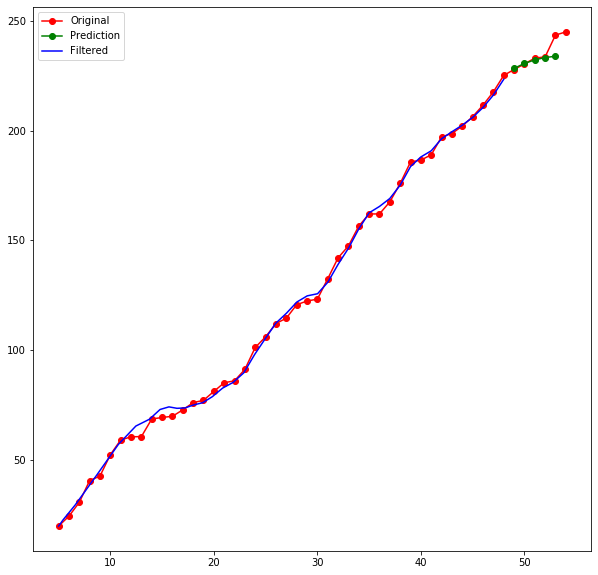

In [111]:
plt.figure(1)
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x, y, 'ro-') #original
plt.plot(xp, yp, 'go-') #predicted kalman
plt.plot(xf, yf, 'b') #kalman filter
plt.legend( ('Original', 'Prediction', 'Filtered') ) 
plt.show()

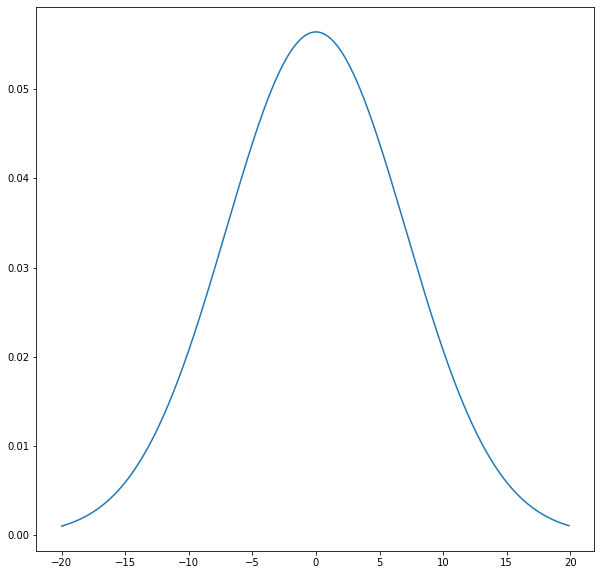

In [73]:
gaussian_plot(0, 50)

In [74]:
# the update function
def update2(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]


# the motion update/predict function
def predict2(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]

In [121]:
# measurements for mu and motions, U
measurements = [5., 6., 7., 9., 10.]
motions = [1., 1., 2., 1., 1.]

# initial parameters
measurement_sig = 4.
motion_sig = 2.
mu = 0.
sig = 10000.

t = len(measurements)

xf = np.zeros(t)
yf = np.zeros(t)

xp = np.zeros(t+1)
yp = np.zeros(t+1)

x = np.zeros(t)
y = np.zeros(t)

xp[0], yp[0] = mu, sig

for n in range(len(measurements)):
    x[n], y[n] = measurements[n], motions[n]
    # measurement update, with uncertainty
    xf[n], yf[n] = update2(xp[n], yp[n], measurements[n], measurement_sig)
    # motion update, with uncertainty
    xp[n+1], yp[n+1] = predict2(xf[n], yf[n], motions[n], motion_sig)

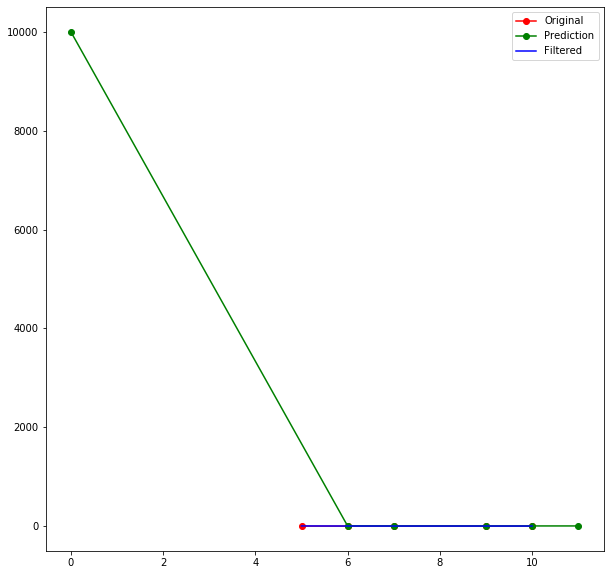

In [122]:
plt.figure(1)
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x, y, 'ro-') #original
plt.plot(xp, yp, 'go-') #predicted kalman
plt.plot(xf, yf, 'b') #kalman filter
plt.legend( ('Original', 'Prediction', 'Filtered') ) 
plt.show()

In [128]:
from ipywidgets import interact

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian2(m1, v1)
    g2 = gaussian2(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

<Figure size 720x720 with 0 Axes>